In [1]:
# import the VGG model from the module vgg.py
from vgg import *

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard,ReduceLROnPlateau
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import copy
import sys
from loguru import logger
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

logger.debug('All modules imported')

Using TensorFlow backend.
2020-02-16 21:35:01.748 | DEBUG    | __main__:<module>:31 - All modules imported


In [2]:
# current working directory from which main.py is located
cur_dir = os.getcwd()

# the data is located in this data_dir
data_dir = os.path.join(cur_dir, 'Dataset')

# the output model and the graph is saved in this 'output_dir'
output_dir = os.path.join(cur_dir, 'Output')

logger.debug("[INFO] loading images...")
data = []
labels = []

# grab the image paths and shuffle them
# for reproducible results, use a constant seed for shuffling
imagePaths = sorted(list(paths.list_images(data_dir) ))
random.seed(2)
random.shuffle(imagePaths)

# loop over the input image paths
for imagePath in imagePaths:

    # load the image
    image = cv2.imread(imagePath)

    # resize it
    image = cv2.resize(image, (64, 64))
    
    # append to the data list
    data.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

logger.debug('[INFO] data loaded complete...')

2020-02-16 21:35:01.833 | DEBUG    | __main__:<module>:10 - [INFO] loading images...
2020-02-16 21:35:20.020 | DEBUG    | __main__:<module>:36 - [INFO] data loaded complete...


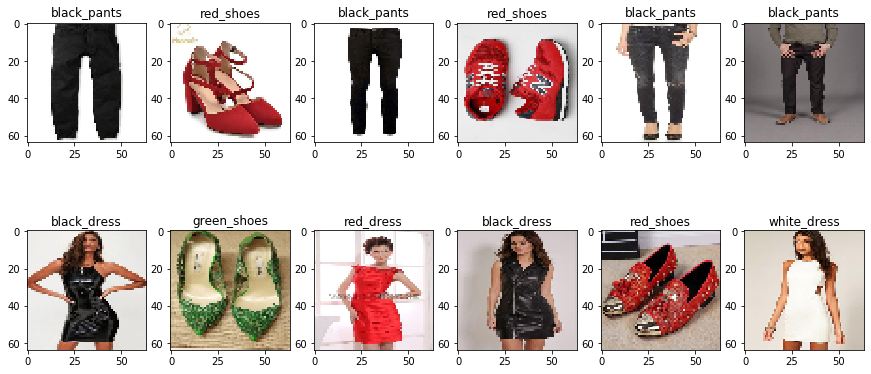

In [3]:
# random.seed(82)
# random.shuffle(list(zip(data, labels)))

row,col = 2,6
fig, axs = plt.subplots(row, col, figsize=(15, 7))
    
count = 0
for r in range(row):
    for ax in axs[r] :
        ax.imshow(cv2.cvtColor(data[count], cv2.COLOR_BGR2RGB))
        ax.set_title(labels[count])
        ax.grid(False)
        count = count + 1        
plt.show()

In [4]:
data_loaded = copy.deepcopy(data)
labels_loaded = copy.deepcopy(labels)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data_loaded, dtype="float") / 255.0
labels = np.array(labels_loaded)

# Binarize labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# save the encoder to output directory
with open(os.path.join(output_dir,'labels'), 'wb') as f:
    pickle.dump(lb, f)

# Randomly split the data into test and train sets (15% test and 85% train)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42)

In [5]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize our VGG-like Convolutional Neural Network
model = VGGNet.build(width=64, height=64, depth=3, classes=len(lb.classes_))

In [6]:
# initialize our initial learning rate, # of epochs to train for,and batch size
INIT_LR = 0.0007
EPOCHS = 100
BS = 64

# Checkpoints between the training steps
model_checkpoint = ModelCheckpoint(filepath='VGG_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=20)
# Termination of training if the loss become Nan
terminate_on_nan = TerminateOnNaN()

# For watching the live loss, accuracy and graphs using tensorboard
t_board = TensorBoard(log_dir='./logs', 
                      histogram_freq=0,
                      batch_size=32, 
                      write_graph=True, 
                      write_grads=False,
                      write_images=False, 
                      embeddings_freq=0, 
                      update_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)

callbacks = [model_checkpoint, t_board, terminate_on_nan, reduce_lr]

# initialize the model and optimizers
opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.999, amsgrad=False)


model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
logger.debug('Training the network...')
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,callbacks=callbacks)


# Save the model locally for use later
model_path = os.path.join(output_dir,  'path_to_my_VGG_model.h5')
model.save(model_path)



2020-02-16 21:35:25.438 | DEBUG    | __main__:<module>:40 - Training the network...


Epoch 1/100
53/53 [==============================] - 109s 2s/step - loss: 1.3691 - acc: 0.5699 - val_loss: 1.2561 - val_acc: 0.7312
Epoch 2/100
53/53 [==============================] - 87s 2s/step - loss: 0.6435 - acc: 0.7874 - val_loss: 2.0560 - val_acc: 0.6394
Epoch 3/100
53/53 [==============================] - 86s 2s/step - loss: 0.5355 - acc: 0.8255 - val_loss: 0.8216 - val_acc: 0.7713
Epoch 4/100
53/53 [==============================] - 84s 2s/step - loss: 0.4822 - acc: 0.8558 - val_loss: 0.4335 - val_acc: 0.8781
Epoch 5/100
53/53 [==============================] - 84s 2s/step - loss: 0.4405 - acc: 0.8526 - val_loss: 0.4021 - val_acc: 0.8881
Epoch 6/100
53/53 [==============================] - 83s 2s/step - loss: 0.4013 - acc: 0.8576 - val_loss: 0.5442 - val_acc: 0.8681
Epoch 7/100
53/53 [==============================] - 83s 2s/step - loss: 0.3697 - acc: 0.8724 - val_loss: 0.3221 - val_acc: 0.8982
Epoch 8/100
53/53 [==============================] - 83s 2s/step - loss: 0.3327 - 

53/53 [==============================] - 82s 2s/step - loss: 0.0929 - acc: 0.9638 - val_loss: 0.1044 - val_acc: 0.9683
Epoch 62/100
53/53 [==============================] - 85s 2s/step - loss: 0.0771 - acc: 0.9653 - val_loss: 0.0974 - val_acc: 0.9649
Epoch 63/100
53/53 [==============================] - 92s 2s/step - loss: 0.0880 - acc: 0.9644 - val_loss: 0.0997 - val_acc: 0.9666
Epoch 64/100
53/53 [==============================] - 88s 2s/step - loss: 0.1010 - acc: 0.9611 - val_loss: 0.0973 - val_acc: 0.9666
Epoch 65/100
53/53 [==============================] - 86s 2s/step - loss: 0.0826 - acc: 0.9670 - val_loss: 0.0889 - val_acc: 0.9683
Epoch 66/100
53/53 [==============================] - 134s 3s/step - loss: 0.0866 - acc: 0.9670 - val_loss: 0.0888 - val_acc: 0.9699
Epoch 67/100
53/53 [==============================] - 134s 3s/step - loss: 0.0771 - acc: 0.9688 - val_loss: 0.0913 - val_acc: 0.9616
Epoch 68/100
53/53 [==============================] - 82s 2s/step - loss: 0.1036 - acc:

2020-02-17 00:07:08.867 | DEBUG    | __main__:<module>:2 - Making predictions and evaluating the trained model.


              precision    recall  f1-score   support

 black_dress       0.95      0.98      0.97        58
 black_pants       0.99      0.98      0.98        81
  blue_dress       0.95      0.97      0.96        77
  blue_pants       0.98      0.95      0.96        83
 green_shoes       1.00      0.94      0.97        81
   red_dress       0.96      0.98      0.97        91
   red_shoes       0.95      0.94      0.94        63
 white_dress       0.96      1.00      0.98        65

    accuracy                           0.97       599
   macro avg       0.97      0.97      0.97       599
weighted avg       0.97      0.97      0.97       599



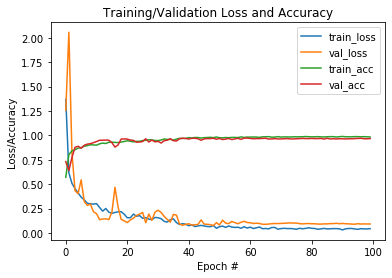

In [7]:
#evaluate the network
logger.debug('Making predictions and evaluating the trained model.')
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))


# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(os.path.join(output_dir ,'vggnet_plot.png'))